In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima.arima.utils import ndiffs
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [2]:
# Read the dataset
df_stock = pd.read_csv('PSEI(2014-2024).csv')
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock = df_stock.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume']).dropna().sort_values(by='Date').set_index('Date')
df_stock

,Close
Date,
2014-04-01,6514.720215
2014-04-02,6587.720215
2014-04-03,6587.080078
2014-04-04,6561.200195
2014-04-07,6614.399902
...,...
2024-03-21,6963.220215
2024-03-22,6881.970215
2024-03-25,6853.100098


## Stationarity
Subtract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times.

And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model.

### ADF Test
We'll use the Augumented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

In [6]:
# Check if the price series is stationary
result = adfuller(df_stock)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.781051502805296
p-value: 0.061031817544298185


Since p-value > 0.05, we need to find the minimum number of differencing needed to be inputed into the model.

In [8]:
# Using ndiffs from pmdarima to find the number of differencing needed
d = ndiffs(df_stock, test='adf')
print(f'Number of Differencing: {d}')

Number of Differencing: 1


ADF Statistic: -22.84777042678849
p-value: 0.0


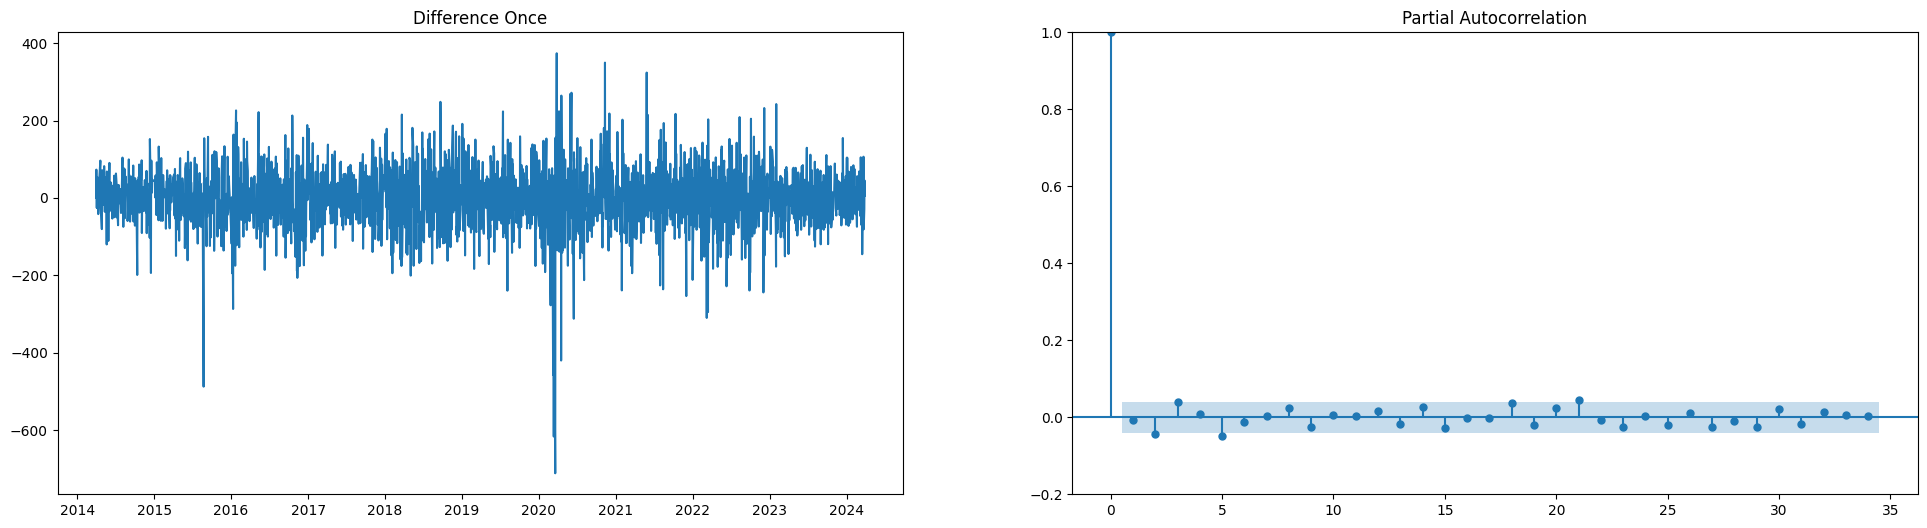

In [31]:
# Differencing the data
df_diff = df_stock['Close'].diff().fillna(0)

result = adfuller(df_diff)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

ax1.plot(df_diff)
ax1.set_title('Difference Once')
plot_pacf(df_diff, ax=ax2);
ax2.set_ylim(-0.2, 1)
plt.show()

We can observe that the PACF lag 5 is significant as it's above the significance line.

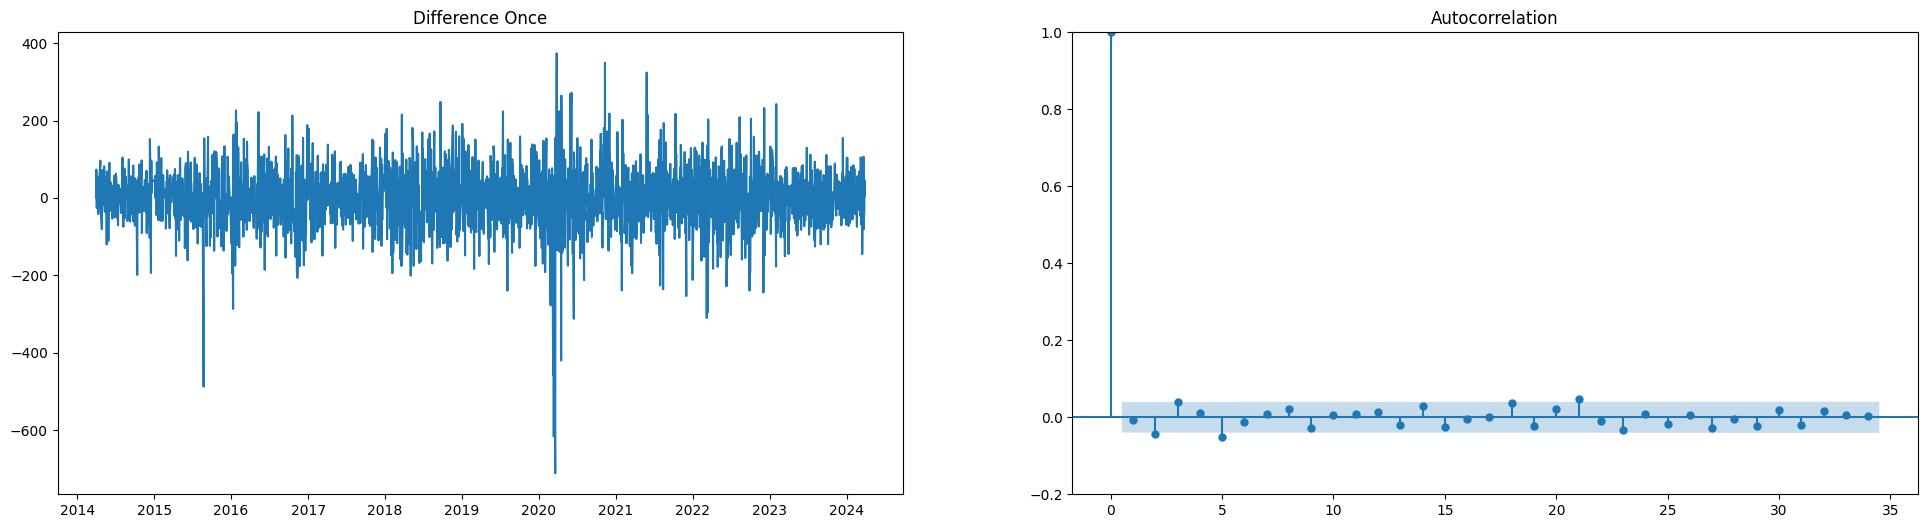

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

ax1.plot(df_diff)
ax1.set_title('Difference Once')
plot_acf(df_diff, ax=ax2);
ax2.set_ylim(-0.2, 1)
plt.show()

In [63]:
model = ARIMA(df_stock['Close'], order=(3, 1, 21))
result = model.fit()

c:\Users\johnk\Documents\03 Code\TSF-GRIP\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\johnk\Documents\03 Code\TSF-GRIP\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\johnk\Documents\03 Code\TSF-GRIP\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [64]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2436
Model:                ARIMA(3, 1, 21)   Log Likelihood              -14093.258
Date:                Tue, 09 Apr 2024   AIC                          28236.516
Time:                        21:55:48   BIC                          28381.458
Sample:                             0   HQIC                         28289.207
                               - 2436                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1248      0.678     -0.184      0.854      -1.453       1.203
ar.L2         -0.4129      0.336     -1.228      0.219      -1.072       0.246
ar.L3         -0.1228      0.535     -0.229      0.8

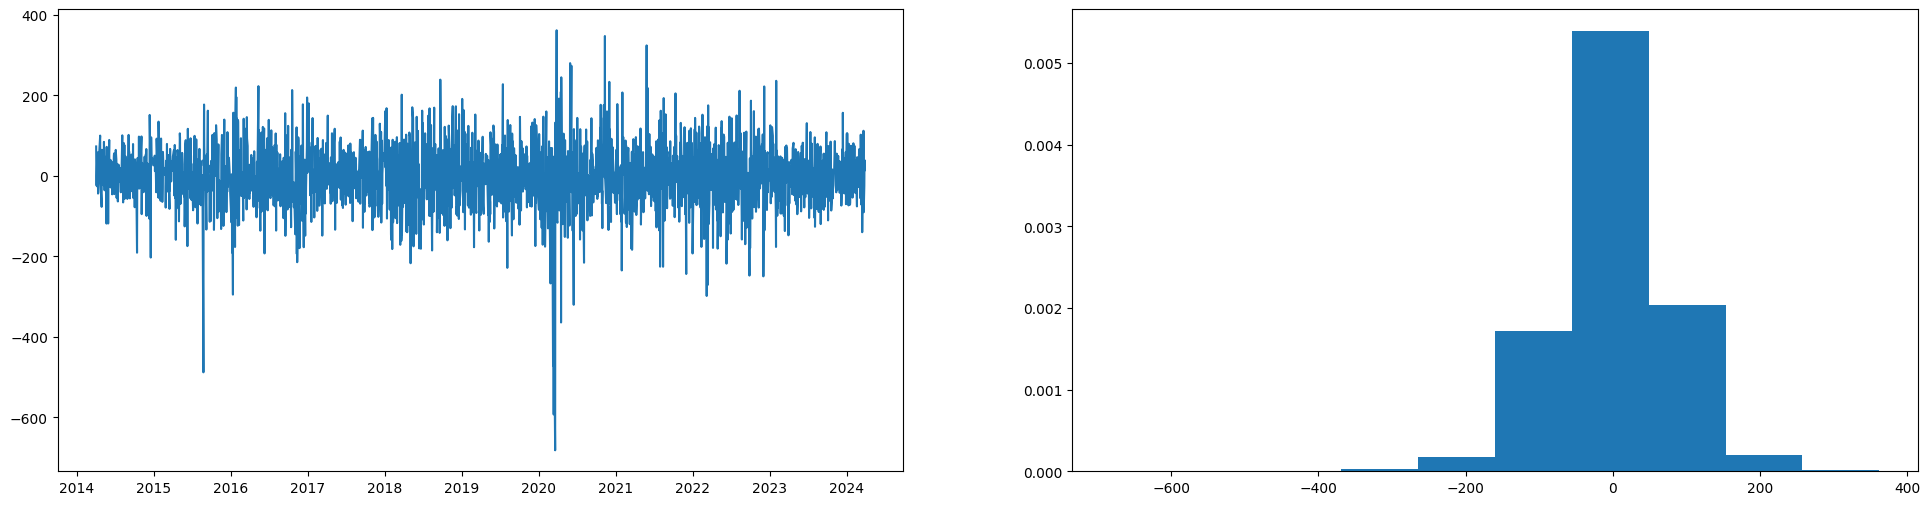

In [65]:
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,6))

ax1.plot(residuals[1:])
ax2.hist(residuals[1:], density=True)
plt.show()

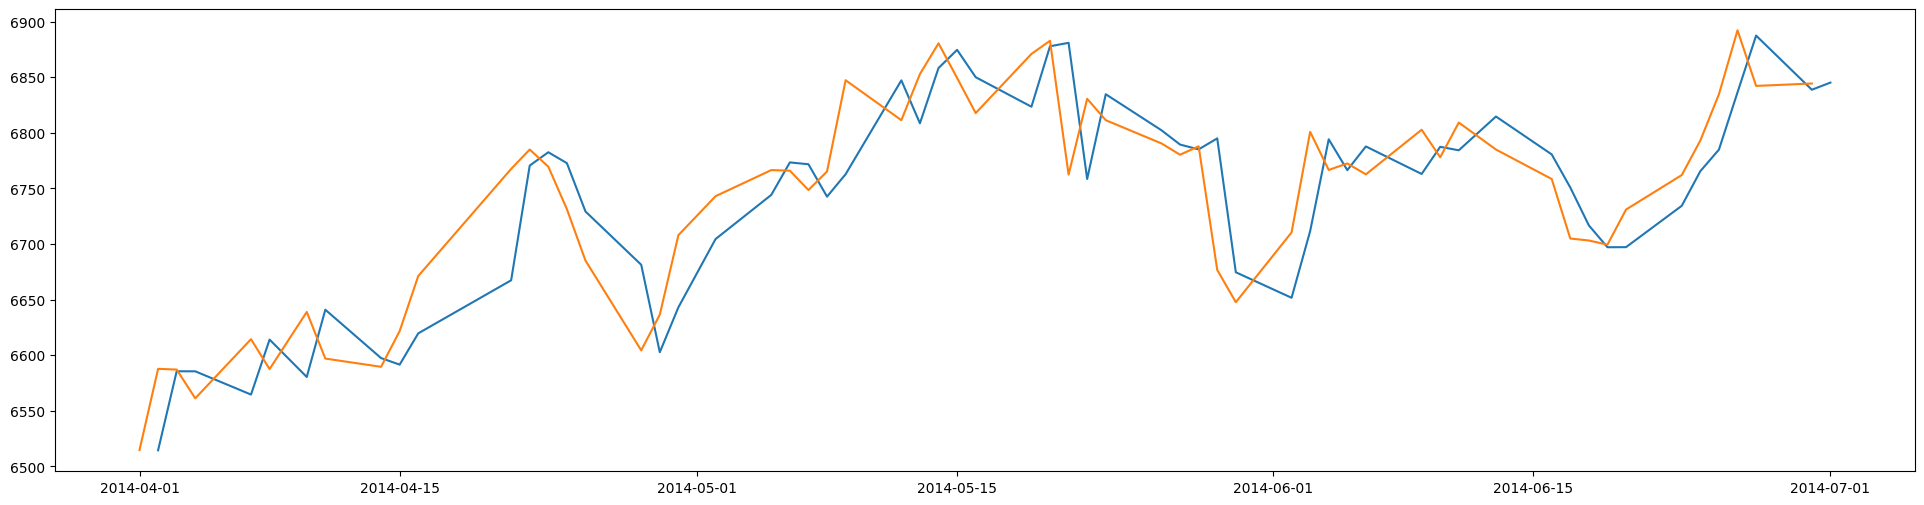

In [67]:
pred = result.predict(start = 1, dynamic=False)

plt.figure(figsize=(24,6))
plt.plot(pred[:60])
plt.plot(df_stock['Close'][:60])